# Reconnaissance d'entités nommées avec SpaCy

La documentation est accessible ici: https://spacy.io/api

## Imports

In [4]:
import os
import re
from collections import Counter, defaultdict
import itertools
import spacy
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

In [ ]:
#Imports & modèle spaCy optimisé
import pickle

with open("clustering_results.pkl", "rb") as f:
    data = pickle.load(f)

clean_texts = data["clean_texts"]
clean_files = data["clean_files"]
clusters = data["clusters"]
N_CLUSTERS = data["N_CLUSTERS"]

print("Textes chargés :", len(clean_texts))


Textes chargés : 320


In [5]:
nlp = spacy.load("fr_core_news_md", disable=["parser", "lemmatizer", "tagger"])

In [6]:
# Extraction doc par doc
data_ner = []

clean_entity_pattern = re.compile(r"^\W+$|^\d+$|^.{1,2}$")

for text, fname, cl in tqdm(zip(clean_texts, clean_files, clusters), total=len(clean_texts)):
    doc = nlp(text)

    ents = []
    for ent in doc.ents:
        if clean_entity_pattern.match(ent.text):
            continue
        ents.append((ent.text, ent.label_))

    data_ner.append({
        "file": fname,
        "cluster": cl,
        "entities": ents
    })

df_ner = pd.DataFrame(data_ner)
df_ner.head()


100%|██████████| 320/320 [02:46<00:00,  1.92it/s]


,file,cluster,entities
0,KB_JB838_1951-01-20_01-00005.txt,0,"[(vendredi M® Rolin, MISC), (Juifs, MISC), (te..."
1,KB_JB838_1951-02-04_01-00020.txt,5,"[(SOIR Fantaisies d’actualité, MISC), (L E bal..."
2,KB_JB838_1951-05-11_01-00002.txt,0,"[(VEILLÉE D'ARMES EN IRAN, MISC), (Jeudi » Téh..."
3,KB_JB838_1951-06-09_01-00001.txt,0,"[(ANNEE-N, LOC), (Suisse, LOC), (POSTAUX, MISC..."
4,KB_JB838_1951-06-15_01-00010.txt,2,"[(VENDREDI, MISC), (METROPOLE a*. LE PALAIS PU..."


# Agrégation des entités par cluster
#### Objectif : connaître les entités dominantes dans chaque cluster.

In [7]:
from collections import Counter

entities_by_cluster = {c: {"PER": Counter(), "LOC": Counter(), "ORG": Counter()}
                       for c in range(N_CLUSTERS)}

for _, row in df_ner.iterrows():
    cl = row["cluster"]
    for ent, label in row["entities"]:
        if label in entities_by_cluster[cl]:
            entities_by_cluster[cl][label][ent] += 1


In [8]:
# affichage des entités les plus fréquentes par cluster
def show_top_entities(cluster_id, top=20):
    print(f"\n=== CLUSTER {cluster_id} ===")
    for ent_type in ["PER","LOC","ORG"]:
        print(f"\n{ent_type}:")
        for ent, count in entities_by_cluster[cluster_id][ent_type].most_common(top):
            print(f" - {ent}: {count}")

# Exemple :
show_top_entities(0)



=== CLUSTER 0 ===

PER:
 - SENT: 54
 - Roi: 48
 - A.F.P.: 34
 - Cheyns: 30
 - Hitler: 25
 - Gaston: 23
 - M. Tshombe: 20
 - Pelé: 20
 - Bertrand: 18
 - Osborne: 18
 - Léon TREICH: 16
 - Dominici: 16
 - Cicéron: 16
 - M. Marien: 16
 - Joëlle: 16
 - Monsieur: 15
 - Elisabeth: 15
 - Léopold II: 15
 - Eisenhower: 15
 - Le Corbusier: 15

LOC:
 - Bruxelles: 222
 - Belgique: 173
 - Paris: 135
 - Etat: 118
 - Angleterre: 71
 - Moscou: 63
 - France: 60
 - Allemagne: 58
 - Londres: 58
 - Congo: 58
 - Etats-Unis: 57
 - la France: 52
 - Liège: 50
 - Anvers: 49
 - de France: 42
 - Italie: 39
 - Belges: 35
 - Gand: 35
 - Suisse: 34
 - Américains: 33

ORG:
 - Conseil: 55
 - Parlement: 30
 - Chambre: 27
 - Sénat: 25
 - Standard: 22
 - Reuter: 19
 - Nations Unies: 19
 - Cour: 17
 - Comité: 16
 - Association: 15
 - ministre de la Santé publique: 15
 - Benelux: 14
 - AFF: 14
 - ministre des Affaires économiques: 12
 - Fagard: 12
 - Justice: 11
 - Yougoslavie: 11
 - Classes moyennes: 11
 - U.R.S.S.: 10
 

# Réseayx éntités clusters

In [9]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()

for cl in range(N_CLUSTERS):
    G.add_node(f"Cluster {cl}", color="red", size=1500)

    for label in ["PER","LOC","ORG"]:
        for ent, count in entities_by_cluster[cl][label].most_common(10):
            node = f"{ent} ({label})"
            G.add_node(node, color="blue", size=600)
            G.add_edge(f"Cluster {cl}", node, weight=count)


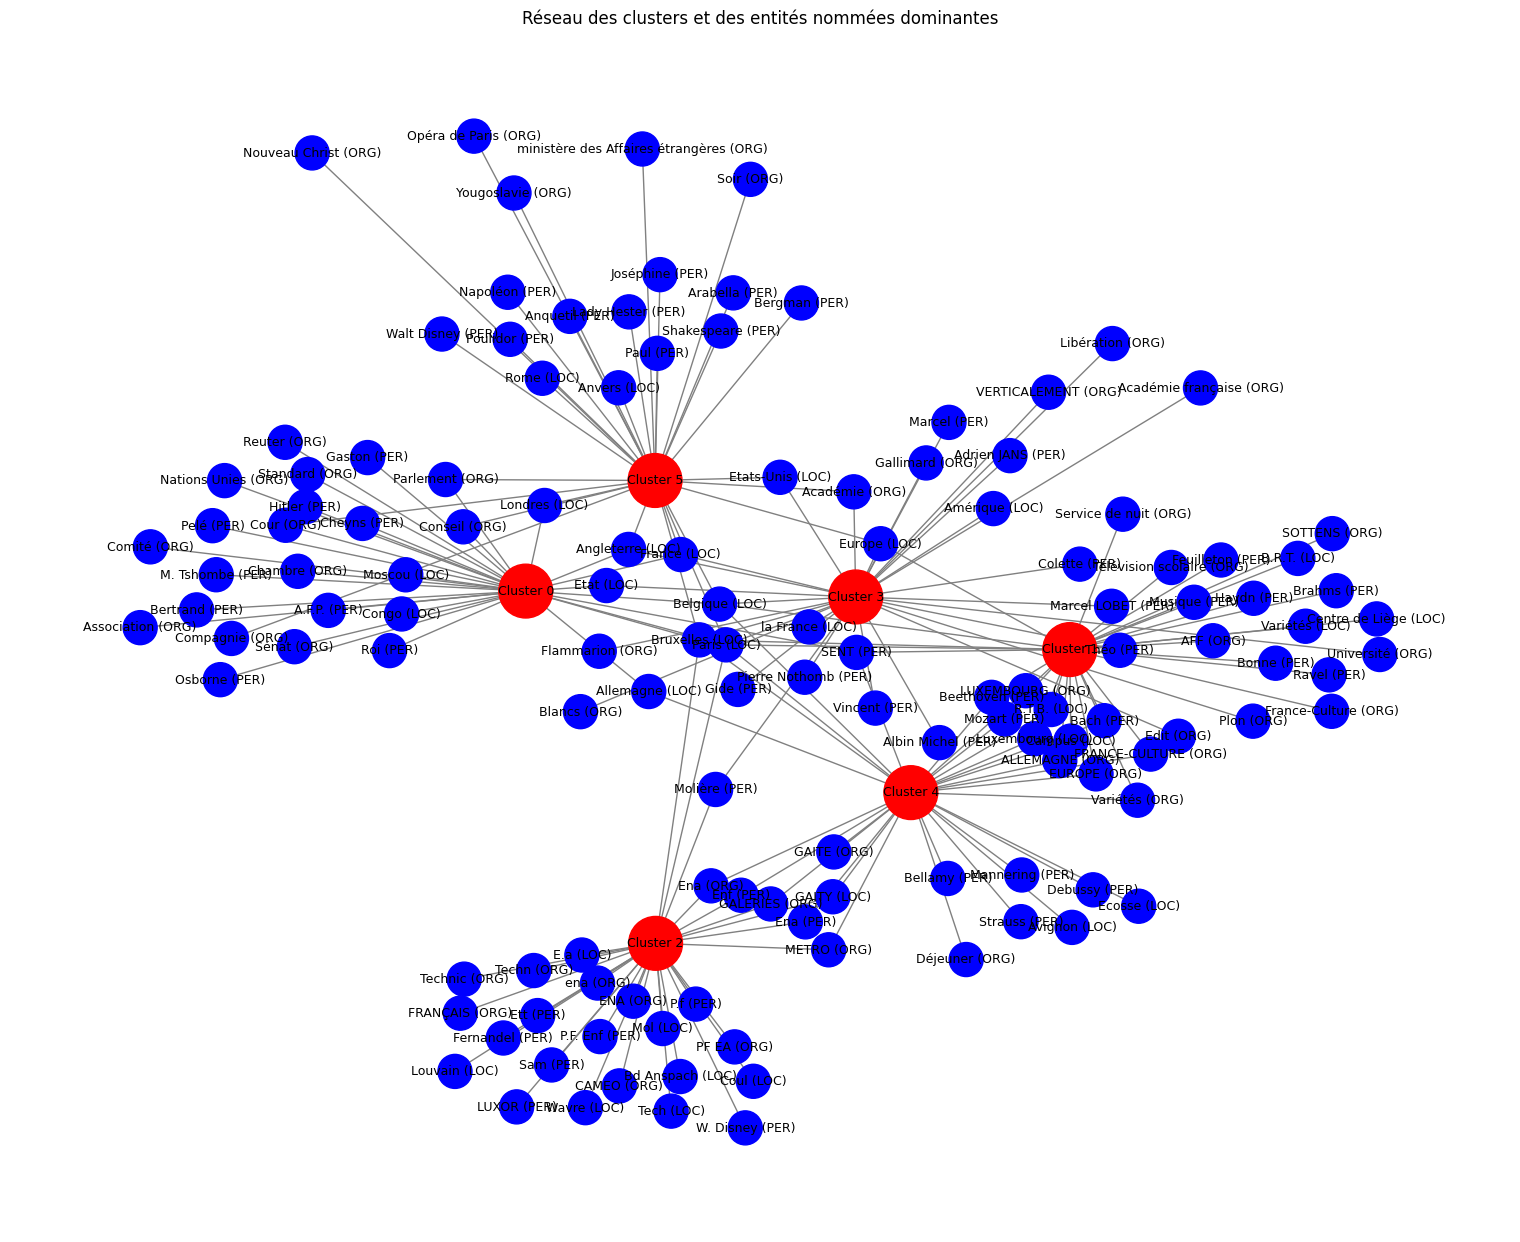

In [10]:
# visualisation
colors = [G.nodes[n]["color"] for n in G.nodes]
sizes = [G.nodes[n]["size"] for n in G.nodes]

plt.figure(figsize=(15,12))
pos = nx.spring_layout(G, k=0.4, seed=42)

nx.draw(G, pos,
        with_labels=True,
        node_color=colors,
        node_size=sizes,
        font_size=9,
        edge_color="gray")

plt.title("Réseau des clusters et des entités nommées dominantes")
plt.show()


# Concurrance thèmes

In [11]:
theme_words = {"sorcière","sorcellerie","féminisme","femme","procès","witch"}
import numpy as np

theme_cooc = Counter()

for text, ents in zip(clean_texts, df_ner["entities"]):
    text_lower = text.lower()
    if any(w in text_lower for w in theme_words):
        for ent, label in ents:
            theme_cooc[(ent, label)] += 1

top_theme = theme_cooc.most_common(20)
top_theme


[(('Paris', 'LOC'), 654),
 (('Bruxelles', 'LOC'), 558),
 (('Belgique', 'LOC'), 399),
 (('Enf', 'PER'), 371),
 (('SENT', 'PER'), 218),
 (('France', 'LOC'), 200),
 (('Mozart', 'PER'), 183),
 (('E.a', 'LOC'), 183),
 (('Etat', 'LOC'), 175),
 (('Londres', 'LOC'), 169),
 (('Beethoven', 'PER'), 167),
 (('Europe', 'LOC'), 156),
 (('E.N.A.', 'MISC'), 155),
 (('Journal', 'MISC'), 155),
 (('R.T.B.', 'LOC'), 147),
 (('ena', 'ORG'), 146),
 (('la France', 'LOC'), 144),
 (('Allemagne', 'LOC'), 141),
 (('Angleterre', 'LOC'), 137),
 (('Etats-Unis', 'LOC'), 136)]

In [12]:
# construire une matrice de cooccurrence
import numpy as np

theme_cooc = Counter()

for text, ents in zip(clean_texts, df_ner["entities"]):
    text_lower = text.lower()
    if any(w in text_lower for w in theme_words):
        for ent, label in ents:
            theme_cooc[(ent, label)] += 1

top_theme = theme_cooc.most_common(20)
top_theme


[(('Paris', 'LOC'), 654),
 (('Bruxelles', 'LOC'), 558),
 (('Belgique', 'LOC'), 399),
 (('Enf', 'PER'), 371),
 (('SENT', 'PER'), 218),
 (('France', 'LOC'), 200),
 (('Mozart', 'PER'), 183),
 (('E.a', 'LOC'), 183),
 (('Etat', 'LOC'), 175),
 (('Londres', 'LOC'), 169),
 (('Beethoven', 'PER'), 167),
 (('Europe', 'LOC'), 156),
 (('E.N.A.', 'MISC'), 155),
 (('Journal', 'MISC'), 155),
 (('R.T.B.', 'LOC'), 147),
 (('ena', 'ORG'), 146),
 (('la France', 'LOC'), 144),
 (('Allemagne', 'LOC'), 141),
 (('Angleterre', 'LOC'), 137),
 (('Etats-Unis', 'LOC'), 136)]

### Heatmap

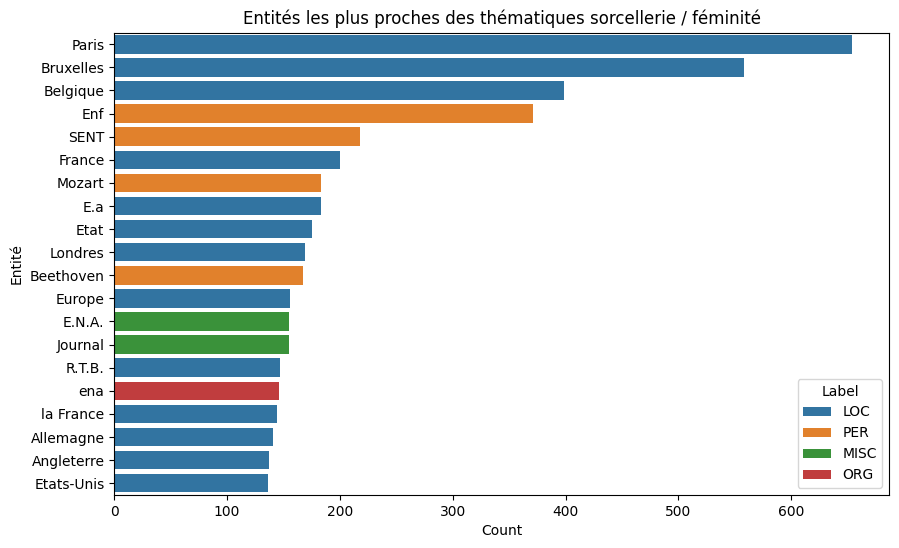

In [13]:
import seaborn as sns
import pandas as pd

df_theme = pd.DataFrame(top_theme, columns=["Entité","Count"])
df_theme["Label"] = df_theme["Entité"].apply(lambda x: x[1])
df_theme["Entité"] = df_theme["Entité"].apply(lambda x: x[0])

plt.figure(figsize=(10,6))
sns.barplot(data=df_theme, x="Count", y="Entité", hue="Label")
plt.title("Entités les plus proches des thématiques sorcellerie / féminité")
plt.show()
